<a href="https://colab.research.google.com/github/bradleywjenks/CIVE_70019_70057/blob/main/notebooks/pressure_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pressure control implementations in water distribution networks


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

### Preamble
This notebook walks through the following pressure control implementations for the operation of water distribution networks:
- Fixed outlet
- Time-based
- Flow modulation
- Model-based optimization

Code implementations for flow modulation and model-based optimal control will be presented.

First, we must clone the GitHub repository and install dependencies (only run this once).

In [1]:
# Run this cell once in Google Colab
!git clone https://github.com/bradleywjenks/CIVE_70019_70057.git
!pip install wntr

Cloning into 'CIVE_70019_70057'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 223 (delta 15), reused 11 (delta 4), pack-reused 190
Receiving objects: 100% (223/223), 2.46 MiB | 6.46 MiB/s, done.
Resolving deltas: 100% (103/103), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 11.0 MB/s eta 0:00:00


In [2]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

# Load operational data


### Fixed outlet control

Enter text here...

In [91]:
# Load data and plot fixed outlet pressure control data...

### Time-based control

Enter text here...

In [ ]:
# Load data and plot fixed outlet pressure control data...

### Flow modulation control

Enter text here...

In [3]:
# Find flow modulation data
data_dir = '/content/CIVE_70019_70057/data/operational_data/data.npy'

# Load operational data
data = np.load(data_dir, allow_pickle=True).item()

# Define datetime list (do not change)
start_date = datetime(2021, 1, 1, 0, 0)
num_values = 576
time_interval = timedelta(minutes=15)
time = [start_date + i * time_interval for i in range(num_values)]

Visualise operational data.

<ipython-input-17-76a6260c2b5a>:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([plt1, plt2, plt3, plt4], labels=['Inlet pressure', 'Outlet pressure', 'Critical pressure', 'Flow'], loc="upper left", bbox_to_anchor=(0.13, 0.88), fontsize=11)


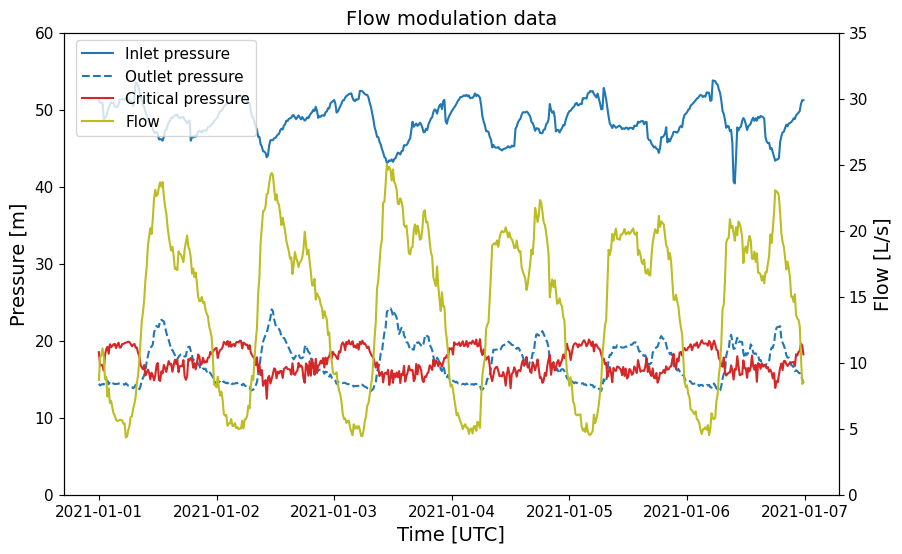

In [17]:
# Create a figure and plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot pressure on the primary y-axis
plt1 = ax1.plot(time, data['p_in'], '-', color='tab:blue')
plt2 = ax1.plot(time, data['p_out'], '--', color='tab:blue')
plt3 = ax1.plot(time, data['p_critical'], '-', color='tab:red')

ax1.set_ylim([0, 60])
ax1.set_title('Flow modulation data', fontsize=14)
ax1.set_ylabel('Pressure [m]', fontsize=14)
ax1.set_xlabel('Time [UTC]', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=11)

# Plot flow on the secondary y-axis
ax2 = ax1.twinx()
plt4 = ax2.plot(time, data['flow'], '-', color='tab:olive')
ax2.set_ylim([0, 35])
ax2.set_ylabel('Flow [L/s]', fontsize=14)
ax2.tick_params(axis='y', which='major', labelsize=11)

# Legend code
fig.legend([plt1, plt2, plt3, plt4], labels=['Inlet pressure', 'Outlet pressure', 'Critical pressure', 'Flow'], loc="upper left", bbox_to_anchor=(0.13, 0.88), fontsize=11)

plt.show()

Compute head loss across simplified 'single pipe' system from the pressure
control valve (PCV) outlet to the critical point (CP).


In [ ]:
# Assign variables
inlet_pressure = data['p_in']
outlet_pressure = data['p_out']
critical_pressure = data['p_critical']
flow = data['flow']
outlet_elev = data['outlet_elev']
critical_elev = data['critical_elev']